In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join, splitext

In [2]:
from os import listdir


input_dir = '../dataset/test'
output_dir = '../dataset/output'
gt_dir = '../dataset/groundtruth'
numImages = 80

# input_dir = '../add_dataset/test'
# output_dir = '../add_dataset/output'
# gt_dir = '../add_dataset/groundtruth'
# numImages = 20

onlyfiles = [f for f in listdir(input_dir) if isfile(join(input_dir, f))]
files = onlyfiles[0:numImages]

In [3]:
def showSubplotImage(img, titlestr="", cmap='gray', interpolation='bicubic', vmin=0, vmax=255):
    """
    Displays a single grayscale image with customizable visualization options.
    """
    plt.imshow(img, cmap=cmap, interpolation=interpolation, vmin=vmin, vmax=vmax)
    plt.xticks([]), plt.yticks([])  # Remove axis ticks
    plt.title(titlestr)
    plt.show()  # Show the image

def setSubplotImage(img, titlestr="", cmap='gray', interpolation='bicubic', vmin=0, vmax=255):
    """
    Displays multiple images in a subplot grid with customizable visualization options.
    """
    n = len(img)  # Number of images

    if n <= 6:
        # If 6 or fewer images, show in a single row
        cols = n
        rows = 1
    else:
        # Otherwise, calculate rows and columns
        cols = int(np.ceil(np.sqrt(n)))
        rows = int(np.ceil(n / cols))

    # Create subplots
    fig, axs = plt.subplots(rows, cols, figsize=(15, 15))
    axs = axs.ravel()  # Flatten axes for easy indexing

    for i in range(n):
        axs[i].imshow(img[i], cmap=cmap, interpolation=interpolation, vmin=vmin, vmax=vmax)
        axs[i].set_title(titlestr[i] if i < len(titlestr) else "")
        axs[i].axis('off')  # Turn off axes

    # Hide any unused subplots
    for i in range(n, len(axs)):
        axs[i].axis('off')

    plt.tight_layout()  # Adjust layout for better visibility
    plt.show()  # Display the subplot grid


In [4]:
def show_images(images, titles):
    plt.figure(figsize=(20, 10))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.xticks([]), plt.yticks([])
    plt.show()

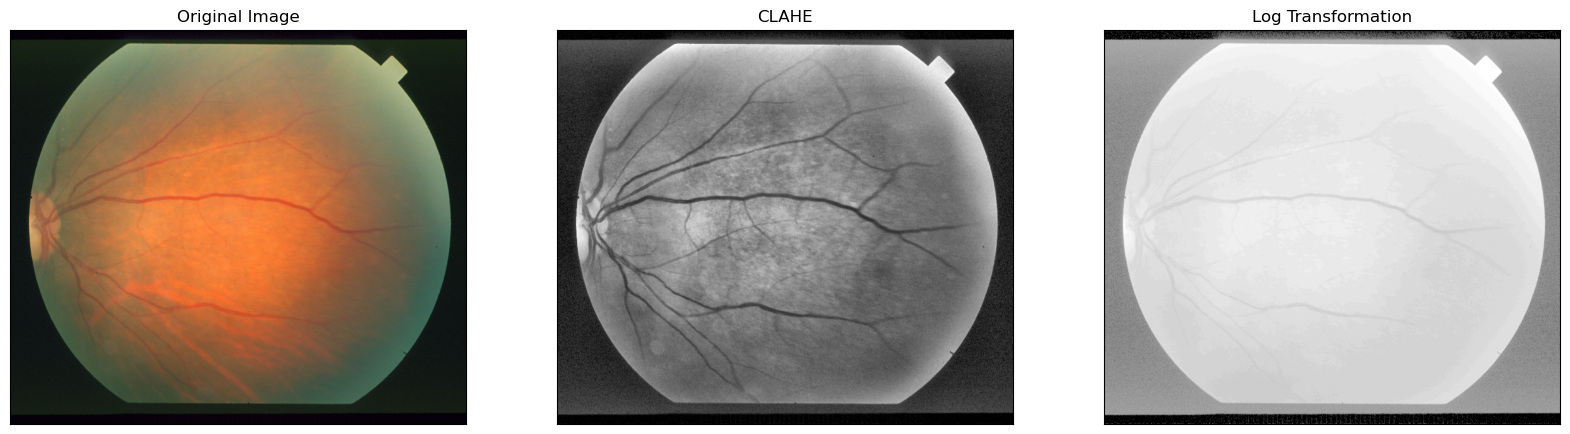

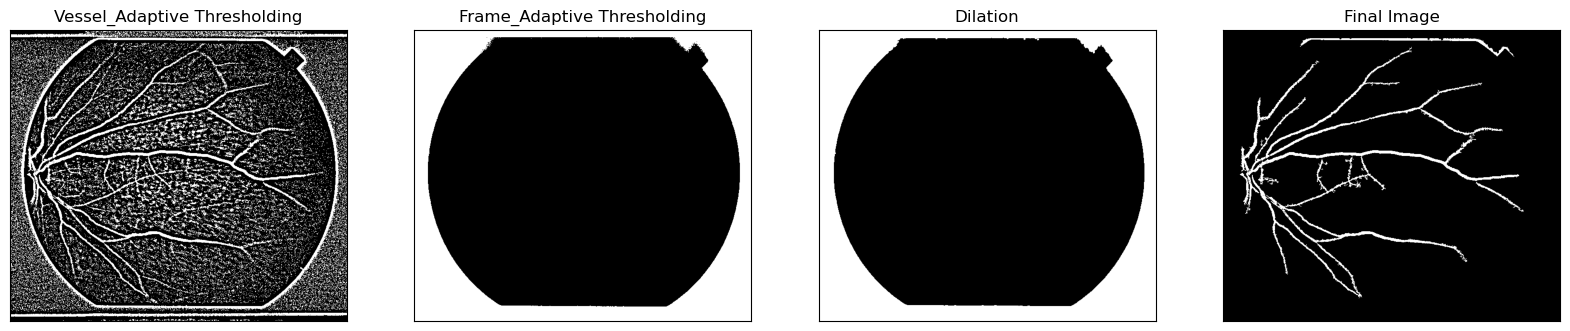

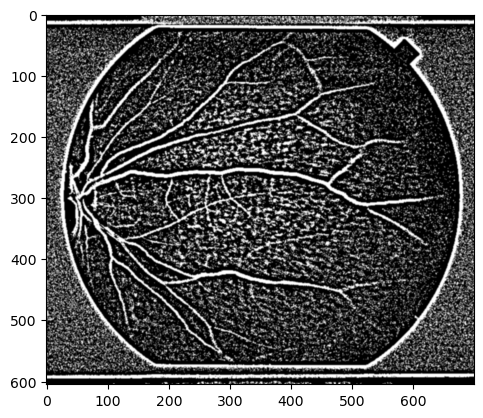

In [5]:
img = cv2.imread('../dataset/test/78.png')

img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# Split the Red, Green and Blue Channel of the RGB Image.
r, g, b = cv2.split(img)

# Create a CLAHE (Contrast Limited Adaptive Histogram Equalization) for contrast enhancement.
vessel_clahe = cv2.createCLAHE(clipLimit = 3, tileGridSize = (10, 10))

# Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) for the Green Channel to enhance the green channel.
vessel_equalize_hist = vessel_clahe.apply(g)

# # Make a Gaussian Blur for "equalizeHist" to smooth the enhanced green channel.
# vessel_gaussian_blur = cv2.GaussianBlur(vessel_equalize_hist, (3, 3), 5)

# Apply adaptive thresholding to the "gaussianBlur" to create a binary image.
vessel_adaptive_threshold = cv2.adaptiveThreshold(vessel_equalize_hist, 1, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 13, 5)

# Apply log transformation to enhance dynamic range and scale it to 8-bit.
frame_log = np.uint8(10 * np.log(2.0 + g))

# # Apply Gaussian blur to the log-transformed image for noise reduction.
# frame_gaussian_blur = cv2.GaussianBlur(frame_log, (5, 5), 0)

# Apply adaptive thresholding to the blurred log-transformed image.
# frame_adaptive_threshold = cv2.adaptiveThreshold(frame_log, 1, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 13, 5)
_, frame_adaptive_threshold = cv2.threshold(frame_log, 1, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# Create a small elliptical structuring element for morphological operations.
# frame_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4, 4))
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4, 4))
# Perform dilation to enlarge the frame of the fundus image.
frame_dilate = cv2.dilate(frame_adaptive_threshold, kernel, iterations = 1)

# Subtract the vessel binary images and frame binary image to remove the frame of the fundus.
outImg = cv2.subtract(vessel_adaptive_threshold, frame_dilate)

# Find connected components in the binary image.
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(outImg, connectivity = 8)

# Iterate through all detected components and remove those smaller than the minimum size.
for i in range(1, num_labels):  # Skip the background (i=0).
    if stats[i, cv2.CC_STAT_AREA] < 300:  # Check if the component area is smaller than the threshold.
        outImg[labels == i] = 0  # Remove the small component by setting its pixels to 0.

# setSubplotImage([img, vessel_equalize_hist, vessel_adaptive_threshold, frame_log, frame_adaptive_threshold, frame_dilate, outImg], ["Original Image", "CLAHE", "Adaptive Thresholding", "Log Transformation", "Adaptive Thresholding", "Dilation", "Final Image"])

show_images([img, vessel_equalize_hist, frame_log], ["Original Image", "CLAHE", "Log Transformation", "Adaptive Thresholding", "Dilation", "Final Image"])

show_images([ vessel_adaptive_threshold, frame_adaptive_threshold, frame_dilate, outImg], [ "Vessel_Adaptive Thresholding", "Frame_Adaptive Thresholding", "Dilation", "Final Image"])



plt.imshow(vessel_adaptive_threshold, cmap='gray', interpolation='bicubic', vmin=0, vmax=1)


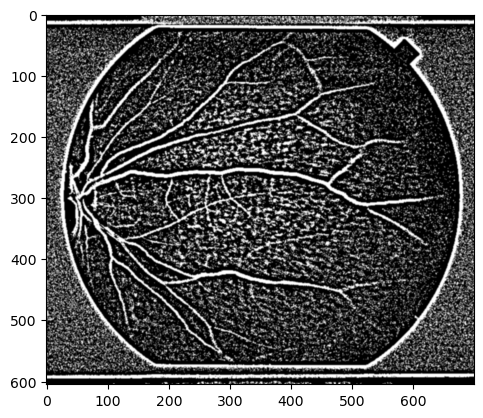

In [6]:
plt.imshow(vessel_adaptive_threshold, cmap='gray', interpolation='bicubic', vmin=0, vmax=1)